# Machine Learning using python
### Nearest neighbors and PCA
sklearn contains multiple ML algorithms and some assicociate helper functions

Main task: use the location variables 'east' and 'north' and the floor area 'fl_area', to predict the price of house 'price' in some house price data

In [13]:
import numpy as np
import pandas as pd

hp = pd.read_csv('/Users/jackhickey/Desktop/python_files/hpdemo.csv',dtype=float)
print(hp)

          ID      east     north     price  fl_area
0        1.0  523800.0  179700.0  107000.0     50.0
1        2.0  533200.0  170900.0   55500.0     66.0
2        3.0  514600.0  175800.0  103000.0     90.0
3        4.0  516000.0  171000.0  187000.0    125.0
4        5.0  533700.0  169200.0   43000.0     50.0
...      ...       ...       ...       ...      ...
1400  1401.0  515600.0  173100.0   68500.0     44.0
1401  1402.0  513200.0  186500.0   58500.0     59.0
1402  1403.0  542900.0  189500.0  247000.0    185.0
1403  1404.0  524900.0  185300.0  153000.0     96.0
1404  1405.0  522000.0  185400.0  146250.0    111.0

[1405 rows x 5 columns]


Stages in the Machine Learning process: 
Data prep,
Choose algorithm,
Identify tuning params,
identification of prediction scoring measure,
Choice of tuning params to optimize scoring measure.


In [15]:
#Data prep: Scaling the data

from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
#to colibrate the scaler use fit
x_scaler.fit(hp[['east','north','fl_area']])

StandardScaler()

In [16]:
#To transfrom some data to z-scores:
X = x_scaler.transform(hp[['east','north','fl_area']])

The array 'X' now contains z-score rescaled columns

In [17]:
print(X[:6,:])

[[-0.46109525 -0.0036912  -1.16501944]
 [ 0.39051366 -1.02696462 -0.73029338]
 [-1.29458482 -0.45718737 -0.07820428]
 [-1.16774945 -1.01533651  0.87275899]
 [ 0.435812   -1.22464244 -1.16501944]
 [ 1.72228503  1.1474914   0.05764762]]


## Choosing a ML algorithm
Firstly the aim here is to predict something, in this case house prices, so a supervised ML algorithm should be used
Secondly, there is a choice as to which one is appropriate- for this case it seems feesable to use the nearest neighbours approach, often house prices are neighbourhood based 

Since we are using the nearest neighbour algorithm the tuning parameters are:
    •The numer of neighest neighbours to look at (k).
    •Where to use a distance weighted mean, or a simple (uniform weighted) mean as a predictor from the k nearest neighbour values.
    •Which distance metric to use (Euclid(^2), or City Block (Manhattan)

Euclid and City block described : In the Euclidean metric, the distance between two points is the length of a straight line joining them, whilst for City Block, it is the distance travelled in the x direction, plus the distance travelled in the y direction (plus the distances travelled in each of the other directions, if the number of dimensions exceeds 2).

We are going to use cross-validation grid search

In [21]:
from sklearn.neighbors import KNeighborsRegressor as NN
#NN is a function to produce nearest neighbor regression objects. For example
#to create a nearest neighbor regression object with k=6, eucli distancde metric
#and uniform mean weighting, enter:
reg_object = NN(n_neighbors=6,weights='uniform',p=2)

#The regression object (reg_object) has a fit method, like the scaler
#object earlier. In this case, it takes as arguments the predictor matrix
#X and the quantity to be predicted - in this case, the house price,
#and fits the regression. 
price = hp['price']/1000.0
reg_object.fit(X,price)

KNeighborsRegressor(n_neighbors=6)

reg_object has now 'learned' to make predictions of the price of a house given its location and floor area

so we test this out using a grid reference 523800E 179750N and floor area of 55 square metres
The predictor variables were re-scaled before fitting the model - and the transformation was via x_scaler. The predictor values must therefore also be rescaled before being fed into the regression model:

In [25]:
predicted_price = reg_object.predict(x_scaler.transform([[523800.0,179750.0,55.0]]))
print(predicted_price , "thousand pounds")

[128.5] thousand pounds


## Optimising the Tuning params

In [26]:
from sklearn.metrics import mean_absolute_error, make_scorer
mae = make_scorer(mean_absolute_error, greater_is_better=False) #mae is the scoring object

In [27]:
# the cross-validation grid search is specified
from sklearn.model_selection import GridSearchCV
opt_nn = GridSearchCV(
    estimator = NN(),
    scoring = mae,
    param_grid = {
        'n_neighbors':range(1,35),
        'weights':['uniform','distance'],
        'p':[1,2]})

The GridSearchCV function takes a number of arguments. Firstly 'estimator' specfies the mschine learning algorithm that you will be using. Here it is NN as used earlier. The next argument 'scoring' specifies the scoring method, here it is 'mae' as set up above. Finally 'param_grid' is a dictionary - each element has the name of one of the tuning parameters as the key, and a list of parameter values as the value. This specifies the values of tuning parameters to search - each combination pf items in the dictionary will be tested, and combination with the best MAE will be selected. The value returned and stored in opt_nn is simialr to the regression object in the earlier example, and has fit and predict methods

First, we fit the model:

In [28]:
opt_nn.fit(X,price)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 35), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [30]:
#Then predict, as before
predicted_hp = opt_nn.predict(
    x_scaler.transform([[523800.0, 179750.0, 55.0]]))
print(predicted_hp)

[122.53520623]


The main difference between this and the earlier example is that when opt_nn performs a fit using the data X and price it carries out a full cross-validation search, rather than using a pre-specified set of tuning parameters. However, in terms of practical use (ie prediction and fitting) the two objects can be used in the same way.

In [31]:
#Another useful task is to see which tuning parameters were actually
#chosen in the optimal model - and what its MAE score was.
#for this use best_estimator_
print(opt_nn.best_estimator_.get_params())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 16, 'p': 1, 'weights': 'distance'}


In [32]:
#best_score_ returns the actual score
print(opt_nn.best_score_)

-26.44326967264284


The negative sign here arises as the algorithm actually attempts to optimise the score, but for MAE, smaller is better. However, looking at the two sets of outputs here, it can be seen that the optimal parameters are use 21 nearest neigbours, based on a city block metric (p=1) and a distance weighted mean as a predictor. This achieves an mean absolute error of around 26.7 thousand pounds. A neater summary can be created by writing a function:

In [33]:
def print_summary(opt_reg_object):
    params = opt_reg_object.best_estimator_.get_params()
    score = - opt_reg_object.best_score_
    print("Nearest neighbours: %8d" % params['n_neighbors'])
    print("Minkowski p       : %8d" % params['p'])
    print("Weighting         : %8s" % params['weights'])
    print("MAE Score         : %8.2f" % score)
    return

In [34]:
print_summary(opt_nn)

Nearest neighbours:       16
Minkowski p       :        1
Weighting         : distance
MAE Score         :    26.44


# Pipelines

The previous model fitting algorithm involved the rescaling of data, and then the application of an ML algorithm, leading to predicted house prices... This can be thought of as a flow => raw data -> transformed data -> predictions. 

pipeline eg:

In [65]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('zscores',StandardScaler()),
                ('NNreg', NN(n_neighbors=6,weights='uniform',p=2))])

The argument here is a list of tuples, of the form (<name>,<object>) where <name> is a string giving a name to each block in the pipeline, and <object> is a regression or transformation object of the kind provided by sklearn. 

The pipeline can have several blocks, but each should have a fit method. All but the last block must also have a transform method. The pipeline itself has a fit method, which first uses the fit method of the object in the first block, then applies transform to the input data. 
    
The pipeline also has a method that applies transforms to the input data, eventually using the predict method from the final pipeline to produce the prediction. In this case, the pipeline applies the rescaling and then fits the model, so that the original data can be used in the pipeline approach, rather than the rescaled data. The following fits the model:

In [66]:
pipe.fit(hp[['east','north','fl_area']],price)

Pipeline(steps=[('zscores', StandardScaler()),
                ('NNreg', KNeighborsRegressor(n_neighbors=6))])

In [67]:
#now repeat using unscaled data
print(pipe.predict([[523800.0,179750.0,55.0]]))

[128.5]


You can also use pipelines with `GridSearchGV`. As before, when you specify a regression model, you don’t need any tuning parameters. However one difference is that in the dictionary part of the param_grid argument the parameters must be referred to in the form <name>__<parameter> where <name> is the block name in the pipeline, and <parameter> is the tuning parameter name – note there are two underline characters. For example NNreg__n_neighbors refers to the number of nearest neighbours parameter in the NNreg block:

In [47]:
pipe = Pipeline([('zscores',StandardScaler()),('NNreg',NN())])

opt_nn2 = GridSearchCV(
    estimator = pipe,
    scoring = mae,
    param_grid = {
        'NNreg__n_neighbors':range(1,35),
        'NNreg__weights':['uniform','distance'],
        'NNreg__p':[1,2]})

Note that pipe is redefined here without any parameters, as these are chosen in the grid search. Having specified the cross-validation procedure (based on a pipeline) the next step is to fit the model again:

In [49]:
opt_nn2.fit(hp[['east','north','fl_area']],price)

GridSearchCV(estimator=Pipeline(steps=[('zscores', StandardScaler()),
                                       ('NNreg', KNeighborsRegressor())]),
             param_grid={'NNreg__n_neighbors': range(1, 35), 'NNreg__p': [1, 2],
                         'NNreg__weights': ['uniform', 'distance']},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [51]:
# as before, predictions can be made, based on the best parameter combination:

print(opt_nn2.predict([[523800.0,179750.0,55.0]]))


[122.53520623]


We can still use the best_estimator_ and best_score_ techniques to find the tuning parameters and score - but recall the naming convention for parameters - (ie NNreg__n_neigbors rather than just n_neighbors). Unfortunately this means that a new function must be written:

In [52]:
def print_summary2(opt_pipe_object):
    params = opt_pipe_object.best_estimator_.get_params()
    score = - opt_pipe_object.best_score_
    print("Nearest neighbours: %8d" % params['NNreg__n_neighbors'])
    print("Minkowski p       : %8d" % params['NNreg__p'])
    print("Weighting         : %8s" % params['NNreg__weights'])
    print("MAE Score         : %8.2f" % score)
    return

#now the optimal pipeline can be seen:
print_summary2(opt_nn2)

Nearest neighbours:       16
Minkowski p       :        1
Weighting         : distance
MAE Score         :    26.42


note that this is identical to the previous cross-validated result, as it is essentially the same model. However the rescaling is dealt with more easily using pipelines.

# Visualising the outcomes

It may be useful to get a broader idea of geographical trends by looking at a predicted price surface for the London area. This involves creating a grid of easting and northing points to cover London, and obtaining an estimate of house price at each grid point. However, the prediction algorithm requires floor area in addition to easting and northing, so firstly we will look at predicted house price at a given location assuming a house has the average floor area.

In [42]:
east_mesh, north_mesh = np.meshgrid(
    np.linspace(505000,555800,100),
    np.linspace(158400,199900,100))
#this gives a list of the eastings and northings that give a grid over the study area
#now we add a third value of floor area

fl_mesh = np.zeros_like(east_mesh)
#This creates a new array of the same shape as but containing zeros.
#This is not of use itself, but creates an array of the correct size. 
#Next, assign every element of this array with the average floor size:
fl_mesh[:,:] = np.mean(hp['fl_area'])



In [43]:
#at the moment the pridiction variables are all available but in the form of 2D arrays
print(east_mesh.shape)
print(north_mesh.shape)

(100, 100)
(100, 100)


In [53]:
#However, opt_nn2 doesn’t expect 2D arrays. For the prediction, 
#each variable should be ‘unravelled’ into single dimensional array  
# - so that the values are just listed as though reading through the 
# matrix as a series running left to right from top to bottom.

grid_predictor_vars = np.array([east_mesh.ravel(),
                               north_mesh.ravel(), fl_mesh.ravel()]).T

#now these can be used in the predict method:
hp_pred = opt_nn2.predict(grid_predictor_vars)

Now the only issue is that hp_pred contains the house prices, but in an unravelled form. To plot the surface, it needs to be back in grid format. This can be achieved with the reshape method. This takes a tuple of dimensions (for example the number of rows and columns needed) and re-shapes an array into this form. It effectively re-arranges an unravelled array back to its 2D form. It can be used in conjuction with the shape attribute of an array to re-shape one array back to the shape of another one. Here hp_pred is re-shaped to have the same dimensions as east_mesh, and stored in a new array called hp_mesh:

In [54]:
hp_mesh = hp_pred.reshape(east_mesh.shape)

Once this is done it is possible to apply the plotting approaches used before to create a 3D plot of predicted house prices for a house with mean floor area:

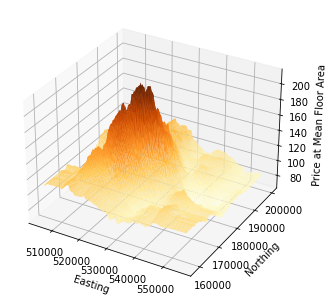

In [56]:
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D

fig = pl.figure()
ax = Axes3D(fig)
ax.plot_surface(east_mesh, north_mesh, hp_mesh, rstride=1, cstride=1, cmap='YlOrBr',lw=0.01)
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_zlabel('Price at Mean Floor Area')
pl.show()

At this stage it is also helpful to create a function to automate the surface drawing. Here the function surf3d is defined - this takes a pipeline and a fixed floor area level, and draws the surface. However it doesn’t actually include the pl.show() command - this is to allow for the fact that rather than showing the figure, it may be required to save it in a file using figsave:

In [57]:
#put it all together in this function

def surf3d(pipe_model,fl_area):
    east_mesh, north_mesh = np.meshgrid(
        np.linspace(505000,555800,100),
        np.linspace(158400,199900,100))
    fl_mesh = np.zeros_like(east_mesh)
    fl_mesh[:,:] = fl_area
    grid_predictor_vars = np.array([east_mesh.ravel(),
        north_mesh.ravel(),fl_mesh.ravel()]).T
    hp_pred = pipe_model.predict(grid_predictor_vars)
    hp_mesh = hp_pred.reshape(east_mesh.shape)
    fig = pl.figure()
    ax = Axes3D(fig)
    ax.plot_surface(east_mesh, north_mesh, hp_mesh, 
        rstride=1, cstride=1, cmap='YlOrBr',lw=0.01)
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    ax.set_zlabel('Price at Mean Floor Area')
    pl.show()
    return

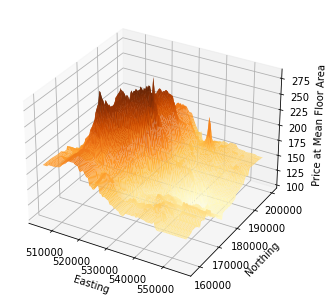

In [59]:
#this can be used to create figures with alternative floor area values
pl.close()
surf3d(opt_nn2,150.0)
pl.show()

# Modify the Pipeline

## PCA analysis

Although the pipeline example only has two stages, it is possible to set up multi-stage pipelines. For example, a principal components analysis (PCA) stage can been added to the pipeline used here. The PCA tools provided by sklearn take the standard form (ie they have fit and transform) methods. Here, they are added to the pipeline in a block named 'prcomp'. This adds another tuning parameter - how many of the components to use. This parameter belongs to the PCA object and is called n_components...  In the GridSearchCV code below, this is referred to as prcomp__n_components. 

In [62]:
from sklearn.decomposition import PCA
pipe = Pipeline([('zscores',StandardScaler()),
                ('prcomp',PCA()),
                ('NNreg',NN())])
opt_nn3 = GridSearchCV(
    estimator = pipe,
    scoring = mae,
    param_grid = {
         'NNreg__n_neighbors':range(1,35),
        'NNreg__weights':['uniform','distance'],
        'NNreg__p':[1,2],
        'prcomp__n_components':[1,2,3]})

opt_nn3.fit(hp[['east','north','fl_area']],price)


GridSearchCV(estimator=Pipeline(steps=[('zscores', StandardScaler()),
                                       ('prcomp', PCA()),
                                       ('NNreg', KNeighborsRegressor())]),
             param_grid={'NNreg__n_neighbors': range(1, 35), 'NNreg__p': [1, 2],
                         'NNreg__weights': ['uniform', 'distance'],
                         'prcomp__n_components': [1, 2, 3]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [63]:
# A quick check shows that in fact the best fit model has 3 parameters:
print(opt_nn3.best_estimator_.get_params()['prcomp__n_components'])

3


In [64]:
# but that it has an identical score to the model without any PCA component:
print(opt_nn3.best_score_)

-26.579866475506634


It can be shown that when the data has been rescaled, distances between points for the z-scores are the same as distances between points specified by the full set of principal components. Since nearest neighbour analysis depends only on distances, this implies that using all 3 components here is equivalent to not using principal component module. Howver the grid search is still usful here, as it has demonstrated that there is no advantage in taking a PVa and reducing to 1 or 2 components. In other cases there may be advantages in doing this.